## Загрузка данных

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
import kagglehub
 
api = KaggleApi()
api.authenticate()

In [4]:
# Hard Drive Test Data
# api.dataset_download_files('backblaze/hard-drive-test-data')

# error
# api.dataset_download_files('ezeydan/hard-drive-failure-data') 

# Hard Drive Test Data
# path = kagglehub.dataset_download("backblaze/hard-drive-test-data")
# print("Path to dataset files:", path)

# Machine Failure Data
# path = kagglehub.dataset_download("binaicrai/machine-failure-data")
# print("Path to dataset files:", path)

# Pumps Failure
# path = kagglehub.dataset_download("davidkazakov/pumps-failure")
# print("Path to dataset files:", path)

# Air pressure system failures in Scania trucks
# path = kagglehub.dataset_download("uciml/aps-failure-at-scania-trucks-data-set")
# print("Path to dataset files:", path)

# Machine Failure Predictions
# path = kagglehub.dataset_download("shashanknecrothapa/machine-failure-predictions")
# print("Path to dataset files:", path)

# Failure Analysis in Power Transformers Dataset
# path = kagglehub.dataset_download("shashwatwork/failure-analysis-in-power-transformers-dataset")
# print("Path to dataset files:", path)

# Hard Drive Failure Prediction ST4000DM000
# path = kagglehub.dataset_download("awant08/hard-drive-failure-prediction-st4000dm000")
# print("Path to dataset files:", path)

# Mechanical Fitting Failure Data
# path = kagglehub.dataset_download("binovi/mechanical-fitting-failure-data")
# print("Path to dataset files:", path)

# Aircraft Sensor and Engine Performance
# path = kagglehub.dataset_download("aadharshviswanath/aircraft-sensor-and-engine-performance")
# print("Path to dataset files:", path)

# Hard Drive Reliability - Failure Prediction
# path = kagglehub.dataset_download("thedevastator/hard-drive-reliability-data-set")
# print("Path to dataset files:", path)

## Анализ

### Датасет Hard Drive Test Data

**Ссылка**: https://www.kaggle.com/datasets/backblaze/hard-drive-test-data

**Описание с kaggle**: Каждый день Backblaze делает снимок каждого работающего жесткого диска, который включает в себя основную информацию о жестком диске (например, емкость, неисправность) и статистику S.M.A.R.T. по каждому диску. Этот набор данных содержит данные за первые два квартала 2016 года. Этот набор данных содержит базовую информацию о жестком диске и 90 столбцов или необработанных и нормализованных значений 45 различных статистических данных S.M.A.R.T. 

Каждая строка представляет собой ежедневный снимок одного жесткого диска:
* date: Date in yyyy-mm-dd format
* serial_number: Manufacturer-assigned serial number of the drive
* model: Manufacturer-assigned model number of the drive
* capacity_bytes: Drive capacity in bytes
* failure: Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.
* 90 variables that begin with 'smart': Raw and Normalized values for 45 different SMART stats as reported by the given drive

Некоторые моменты, которые следует учитывать при обработке данных:
* Значение статистики S.M.A.R.T. может различаться в зависимости от производителя и модели. Возможно, более информативным будет сравнение накопителей, схожих по модели и производителю
* Некоторые столбцы S.M.A.R.T. могут содержать значения за пределами допустимых значений
* При сбое диска столбцу "сбой" в день сбоя присваивается значение 1, и, начиная со следующего дня, диск будет удален из набора данных. Кроме того, каждый день добавляются новые диски. Это означает, что общее количество дисков в день может меняться.
* S.M.A.R.T. 9 - это количество часов, в течение которых диск использовался. Чтобы рассчитать срок службы диска в днях, разделите это число на 24.

**Выводы**:
1. Было замечено ряд особенностей в составе данных ВР: 
* В частности наблюдение первого дня 01.01.2016 дублируется для всех серийных номеров. 
* Также пропущены значения за период февраль-март 2016. Это делит текущую выборку на две части: до 22.01.2016 и с 01.04.2016 по 30.04.2016 (см. рис.1). Почти все серийные номера (> 600 тыс.) не сломались и по ним есть данные, при этом только 15 ломаются в последнюю дату (см. рис.3). 
* (?) Не понятно почему есть наблюдения, по которым данные обрываются без выставления таргета равного 1 (см. рис.2)

![рис. 1](./pics/backblaze_days_dist_hist.png) 
![рис. 2](./pics/backblaze_live_not_all_period.png)
![рис. 3](./pics/backblaze_failure_1.png) 

**Результат анализа:** 

Итоговая выборка будет содержать данные как на рис.2, где диски, которые работали на всем периоде, будут проигнорированы за исключением 1000 наблюдений. Код для создания выборки следующий:


import os 
os.chdir('H:/Projects_folder/autolabeling_time_series_data/')


    import pandas as pd
    import numpy as np
    from datetime import datetime as dt
    import matplotlib.pyplot as plt
    import seaborn as sns
    raw_data = pd.read_csv('data/kagglehub/datasets/backblaze/hard-drive-test-data/versions/1/harddrive.csv')
    target_and_date_df = raw_data.loc[:, ['serial_number','failure']].drop_duplicates(keep='last').reset_index()
    target_and_date_df['target_last_date'] = target_and_date_df['index'].apply(lambda i: raw_data.loc[i, 'date'])
    target_and_date_df_1 = target_and_date_df[target_and_date_df.target_last_date != '2016-01-01']
    target_and_date_df_1.loc[:,'days_num'] = target_and_date_df_1.loc[:,'target_last_date'].apply(lambda x: (pd.to_datetime(x) - pd.Timestamp('2016-01-01')).days )
    sn_before_118 = target_and_date_df_1.loc[(target_and_date_df_1.days_num <= 118)|(target_and_date_df_1.failure==1), 'serial_number'].to_list()
    sn_add_after_118 = target_and_date_df_1.loc[(target_and_date_df_1.days_num > 118)|(target_and_date_df_1.failure!=1), 'serial_number'].sample(n=1000, random_state=21).to_list()
    sample_sn1 = sn_before_118+sn_add_after_118
    sample1_sn = raw_data.loc[raw_data.serial_number.isin(sample_sn1)]
    fetures_nan_median = sample1_sn.notna().sum().median()
    nan_df = sample1_sn.notna().sum()
    nan_df = nan_df[nan_df > fetures_nan_median]
    sample1_sn.loc[:,nan_df.index.to_list()].to_excel('data/kagglehub/datasets/backblaze/hard-drive-test-data/dataset.xlsx')



In [1]:
import os 
os.chdir('H:/Projects_folder/autolabeling_time_series_data/')

import pandas as pd
import numpy as np
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Hard Drive Test Data 
raw_data = pd.read_csv('data/kagglehub/datasets/backblaze/hard-drive-test-data/versions/1/harddrive.csv')
raw_data.head()

# пример поломки через какое-то время 
# raw_data.loc[raw_data.serial_number=='W0Q6KWV8']

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
(raw_data.smart_9_raw / 24).describe().round(2)

count    3179295.00
mean         664.55
std          522.77
min            0.17
25%          236.62
50%          569.50
75%          914.79
max         3714.96
Name: smart_9_raw, dtype: float64

In [7]:
raw_data.failure.value_counts()

failure
0    3179080
1        215
Name: count, dtype: int64

In [8]:
failed_drives = raw_data.loc[raw_data.failure==1, 'serial_number']
failed_drives

30285      WD-WCC4MKDL77ZK
31847             Z300KHN0
37041             Z3015V4D
46720             W3006E5B
87830      WD-WCC4MKDL77ZK
                ...       
3084227           W0Q6KWV8
3100634           S300XP36
3105860           W300T2RC
3136939           Z302A13D
3139403     JK11A8B9J90WMF
Name: serial_number, Length: 215, dtype: object

In [9]:
count_falure_rows = raw_data[raw_data.date != '2016-01-01'].groupby(by=['serial_number'], as_index=False).agg({'failure':'count'}).sort_values(['failure','serial_number'], ascending=[False, True])

assert count_falure_rows.shape == count_falure_rows.drop_duplicates().shape, 'diff'

print(count_falure_rows.shape)

(65989, 2)


In [10]:
count_falure_rows = raw_data.groupby(by=['serial_number'], as_index=False).agg({'failure':'count'}).sort_values(['failure','serial_number'], ascending=[False, True]).reset_index()

assert count_falure_rows.shape == count_falure_rows.drop_duplicates().shape, 'diff'

print(count_falure_rows.shape)
print(count_falure_rows.describe())
print(count_falure_rows.failure.value_counts())
count_falure_rows

(65993, 3)
              index       failure
count  65993.000000  65993.000000
mean   32996.000000     48.176246
std    19050.682494      9.881539
min        0.000000      1.000000
25%    16498.000000     52.000000
50%    32996.000000     52.000000
75%    49494.000000     52.000000
max    65992.000000     52.000000
failure
52    56327
30     6052
21      926
8       926
22      519
5       145
6       139
50      103
49       67
24       64
19       63
12       56
44       56
2        55
29       52
16       50
51       42
47       20
34       19
46       19
45       18
48       16
41       16
43       16
28       16
18       15
1        15
38       15
11       14
4        13
9        12
27       12
3        11
36        9
37        9
14        9
25        9
20        8
32        8
7         8
31        6
23        6
39        6
17        5
35        4
33        4
40        3
13        3
10        3
15        2
42        1
26        1
Name: count, dtype: int64


,index,serial_number,failure
0,0,13H2B97AS,52
1,1,13H32WEAS,52
2,2,13H6A21GS,52
3,3,13H7X2HAS,52
4,4,13H85BMGS,52
...,...,...,...
65988,52605,Z30485H7,1
65989,57107,Z304N9SP,1
65990,59687,Z305BK67,1
65991,60493,Z305D58A,1


In [11]:
target_and_date_df = raw_data.loc[:, ['serial_number','failure']].drop_duplicates(keep='last').reset_index()
target_and_date_df['target_last_date'] = target_and_date_df['index'].apply(lambda i: raw_data.loc[i, 'date'])
target_and_date_df

,index,serial_number,failure,target_last_date
0,65930,S301146W,0,2016-01-01
1,69468,Z3025LCN,0,2016-01-01
2,73769,PL1301LAG3594H,0,2016-01-01
3,79885,Z300GPY9,0,2016-01-01
4,87830,WD-WCC4MKDL77ZK,1,2016-01-01
...,...,...,...,...
66187,3179290,MJ1311YNG3G5NA,0,2016-04-29
66188,3179291,Z3016V0V,0,2016-04-29
66189,3179292,MJ1323YNG1LZJC,0,2016-04-29
66190,3179293,S300YQXW,0,2016-04-29


In [12]:
target_and_date_df_1 = target_and_date_df[target_and_date_df.target_last_date != '2016-01-01']
target_and_date_df_1

,index,serial_number,failure,target_last_date
10,120330,WD-WCC4M3TTXF1Y,0,2016-01-02
11,123475,S301146W,1,2016-01-02
12,127013,Z3025LCN,1,2016-01-02
13,131316,PL1301LAG3594H,1,2016-01-02
14,132947,Z30054Q5,0,2016-01-02
...,...,...,...,...
66187,3179290,MJ1311YNG3G5NA,0,2016-04-29
66188,3179291,Z3016V0V,0,2016-04-29
66189,3179292,MJ1323YNG1LZJC,0,2016-04-29
66190,3179293,S300YQXW,0,2016-04-29


In [13]:
target_and_date_df_1.loc[:,'days_num'] = target_and_date_df_1.loc[:,'target_last_date'].apply(lambda x: (pd.to_datetime(x) - pd.Timestamp('2016-01-01')).days )
target_and_date_df_1

C:\Users\Илья\AppData\Local\Temp\ipykernel_19128\3012745578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_and_date_df_1.loc[:,'days_num'] = target_and_date_df_1.loc[:,'target_last_date'].apply(lambda x: (pd.to_datetime(x) - pd.Timestamp('2016-01-01')).days )


,index,serial_number,failure,target_last_date,days_num
10,120330,WD-WCC4M3TTXF1Y,0,2016-01-02,1
11,123475,S301146W,1,2016-01-02,1
12,127013,Z3025LCN,1,2016-01-02,1
13,131316,PL1301LAG3594H,1,2016-01-02,1
14,132947,Z30054Q5,0,2016-01-02,1
...,...,...,...,...,...
66187,3179290,MJ1311YNG3G5NA,0,2016-04-29,119
66188,3179291,Z3016V0V,0,2016-04-29,119
66189,3179292,MJ1323YNG1LZJC,0,2016-04-29,119
66190,3179293,S300YQXW,0,2016-04-29,119


<Axes: xlabel='days_num', ylabel='Count'>

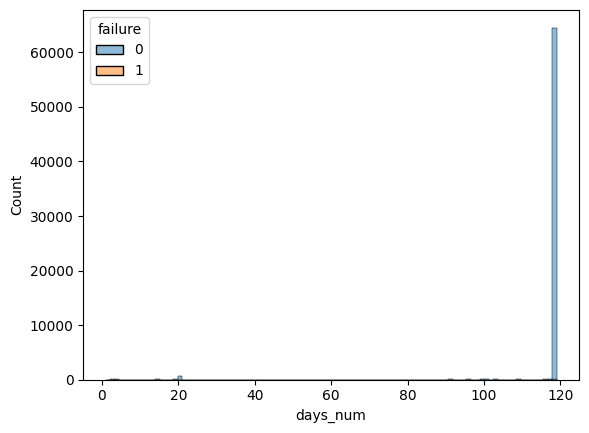

In [17]:
sns.histplot(data=target_and_date_df_1[(target_and_date_df_1.days_num <= 120)], x='days_num', hue='failure', bins=100)

<Axes: xlabel='days_num', ylabel='Count'>

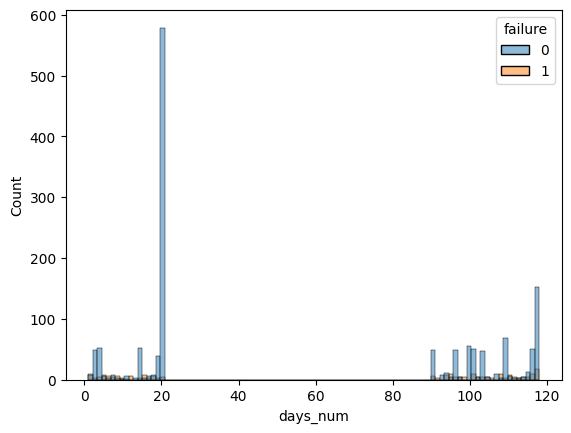

In [14]:
sns.histplot(data=target_and_date_df_1[(target_and_date_df_1.days_num <= 118)], x='days_num', hue='failure', bins=100)

<Axes: xlabel='days_num', ylabel='Count'>

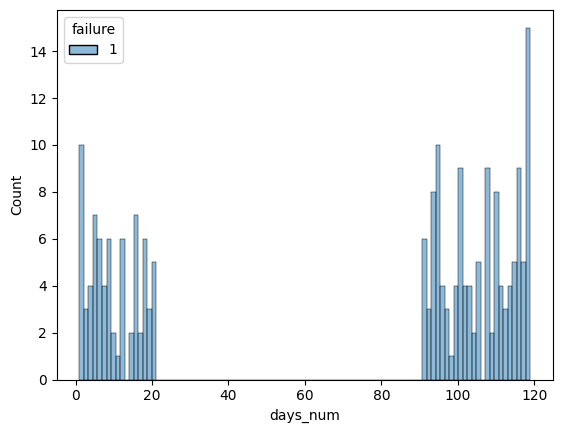

In [15]:
sns.histplot(data=target_and_date_df_1[target_and_date_df_1.failure==1], x='days_num', hue='failure', bins=100)

In [16]:
raw_data.loc[raw_data.serial_number=='Z3016V0V', ['serial_number', 'date']].head(), raw_data.loc[raw_data.serial_number=='Z3016V0V', ['serial_number', 'date']].tail(), raw_data[raw_data.serial_number=='Z3016V0V'].shape[0]

(       serial_number        date
 57540       Z3016V0V  2016-01-01
 115085      Z3016V0V  2016-01-01
 172630      Z3016V0V  2016-01-02
 230236      Z3016V0V  2016-01-03
 287842      Z3016V0V  2016-01-04,
         serial_number        date
 2920722      Z3016V0V  2016-04-25
 2985468      Z3016V0V  2016-04-26
 3050167      Z3016V0V  2016-04-27
 3114729      Z3016V0V  2016-04-28
 3179291      Z3016V0V  2016-04-29,
 52)

In [33]:
target_and_date_df_1.loc[(target_and_date_df_1.failure!=1)&(target_and_date_df_1.days_num>1)]

,index,serial_number,failure,target_last_date,days_num
22,193227,JK11A8B9HTY23F,0,2016-01-03,2
24,211704,Z304JD7V,0,2016-01-03,2
25,218233,S3007K7N,0,2016-01-03,2
27,230542,6XW1V470,0,2016-01-04,3
28,231522,5XW03AL1,0,2016-01-04,3
...,...,...,...,...,...
66187,3179290,MJ1311YNG3G5NA,0,2016-04-29,119
66188,3179291,Z3016V0V,0,2016-04-29,119
66189,3179292,MJ1323YNG1LZJC,0,2016-04-29,119
66190,3179293,S300YQXW,0,2016-04-29,119


In [35]:
# интересно понять почему не все рабочие (failure==1 нигде не было) диски дожили до конца (нет 53 строк в датасете)
# raw_data.loc[raw_data.serial_number=='5XW1AX7F',['date','smart_9_normalized', 'smart_9_raw']]
# raw_data.loc[raw_data.serial_number=='JK11A8B9J8G8UF',['date','smart_9_normalized', 'smart_9_raw']]
# raw_data.loc[raw_data.serial_number=='Z30271GD',['date','smart_9_normalized', 'smart_9_raw']]

In [ ]:
sn_before_118 = target_and_date_df_1.loc[(target_and_date_df_1.days_num <= 118)|(target_and_date_df_1.failure==1), 'serial_number'].to_list()
sn_add_after_118 = target_and_date_df_1.loc[(target_and_date_df_1.days_num > 118)|(target_and_date_df_1.failure!=1), 'serial_number'].sample(n=1000, random_state=21).to_list()

sample_sn1 = sn_before_118+sn_add_after_118

In [50]:
sample1_sn = raw_data.loc[raw_data.serial_number.isin(sample_sn1)]
sample1_sn

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
47,2016-01-01,Z304AESX,ST4000DM000,1.976651e-311,0,114,67192248,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,2016-01-01,W30061M8,ST4000DM000,1.976651e-311,0,118,175636848,NaN,NaN,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,2016-01-01,Z300WG7R,ST4000DM000,1.976651e-311,0,114,76974640,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,2016-01-01,5XW00K1P,ST31500541AS,7.412476e-312,0,119,203832543,NaN,NaN,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,2016-01-01,PL2331LAGPRW3J,HGST HMS5C4040ALE640,1.976651e-311,0,100,0,134.0,100.0,138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179053,2016-04-29,S300Z5AS,ST4000DM000,1.976651e-311,0,114,68647168,NaN,NaN,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3179079,2016-04-29,PL1321LAG33XVH,Hitachi HDS5C4040ALE630,1.976651e-311,0,100,0,135.0,97.0,133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3179148,2016-04-29,PL1331LAGSARZH,HGST HMS5C4040ALE640,1.976651e-311,0,100,0,133.0,105.0,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3179234,2016-04-29,Z302F381,ST4000DM000,1.976651e-311,0,117,146385792,NaN,NaN,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
sample1_sn.describe().round(2)

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
count,78259.0,78259.00,78259.00,7.825900e+04,29751.0,29751.00,78259.00,78259.00,78259.00,78259.00,...,1174.0,1.174000e+03,1174.00,1.174000e+03,1174.00,1.174000e+03,1371.00,1371.0,0.0,0.0
mean,0.0,0.00,114.56,6.724446e+07,122.3,55.07,107.47,508.86,99.99,33.39,...,1.0,1.014443e+08,1.76,1.962585e+08,3.78,9.021210e+07,102.33,0.0,NaN,NaN
std,0.0,0.05,23.41,8.028682e+07,27.4,51.27,20.51,1359.68,0.44,448.90,...,0.0,6.913920e+07,8.64,1.350881e+08,16.37,6.203494e+07,15.10,0.0,NaN,NaN
min,0.0,0.00,45.00,0.000000e+00,100.0,0.00,70.00,0.00,83.00,1.00,...,1.0,4.292900e+04,1.00,1.650000e+02,1.00,0.000000e+00,100.00,0.0,NaN,NaN
25%,0.0,0.00,100.00,0.000000e+00,100.0,0.00,94.00,0.00,100.00,4.00,...,1.0,2.362704e+07,1.00,4.599075e+07,1.00,2.119097e+07,100.00,0.0,NaN,NaN
50%,0.0,0.00,113.00,2.505447e+07,132.0,96.00,99.00,0.00,100.00,11.00,...,1.0,1.310820e+08,1.00,2.516708e+08,1.00,1.159656e+08,100.00,0.0,NaN,NaN
75%,0.0,0.00,117.00,1.321874e+08,134.0,104.00,117.00,558.00,100.00,22.00,...,1.0,1.659175e+08,1.00,3.223254e+08,1.00,1.475712e+08,100.00,0.0,NaN,NaN
max,0.0,1.00,200.00,9.378436e+08,252.0,163.00,253.00,9683.00,100.00,17772.00,...,1.0,1.858673e+08,100.00,3.623561e+08,100.00,1.661026e+08,200.00,0.0,NaN,NaN


In [53]:
sample1_sn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78259 entries, 47 to 3179293
Data columns (total 95 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  78259 non-null  object 
 1   serial_number         78259 non-null  object 
 2   model                 78259 non-null  object 
 3   capacity_bytes        78259 non-null  float64
 4   failure               78259 non-null  int64  
 5   smart_1_normalized    78259 non-null  int64  
 6   smart_1_raw           78259 non-null  int64  
 7   smart_2_normalized    29751 non-null  float64
 8   smart_2_raw           29751 non-null  float64
 9   smart_3_normalized    78259 non-null  int64  
 10  smart_3_raw           78259 non-null  int64  
 11  smart_4_normalized    78259 non-null  int64  
 12  smart_4_raw           78259 non-null  int64  
 13  smart_5_normalized    78259 non-null  int64  
 14  smart_5_raw           78259 non-null  int64  
 15  smart_7_normalized   

In [59]:
fetures_nan_median = sample1_sn.notna().sum().median()
nan_df = sample1_sn.notna().sum()
nan_df = nan_df[nan_df > fetures_nan_median]
nan_df

date                    78259
serial_number           78259
model                   78259
capacity_bytes          78259
failure                 78259
smart_1_normalized      78259
smart_1_raw             78259
smart_3_normalized      78259
smart_3_raw             78259
smart_4_normalized      78259
smart_4_raw             78259
smart_5_normalized      78259
smart_5_raw             78259
smart_7_normalized      78259
smart_7_raw             78259
smart_9_normalized      78259
smart_9_raw             78259
smart_10_normalized     78259
smart_10_raw            78259
smart_12_normalized     78259
smart_12_raw            78259
smart_184_normalized    43648
smart_184_raw           43648
smart_187_normalized    43648
smart_187_raw           43648
smart_188_normalized    43648
smart_188_raw           78259
smart_189_normalized    43642
smart_189_raw           43642
smart_190_normalized    43670
smart_190_raw           43670
smart_192_normalized    73232
smart_192_raw           73232
smart_193_

In [68]:
sample1_sn.loc[:,nan_df.index.to_list()].to_csv('data/kagglehub/datasets/backblaze/hard-drive-test-data/dataset.csv',sep=';')

### Italian  Power Suply

**Ссылка**: https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.datasets.load_italy_power_demand.html#sktime.datasets.load_italy_power_demand sktime

**Описание**: В датасете представлены результаты сбора показателей потребления электроэнергии на протяжении 24 ч. для двух периодов (? не помню: июлю-октябрь и другой). Первый период имеет метку 1, второй метку 2. 

![рис. 4](./pics/ItalyPowerSuply_2clusters_examples.png) 

**Выводы**:

**Результат анализа:** 


In [73]:
from sktime.datasets import load_italy_power_demand

# load an example time series panel in pd-multiindex mtype
X, y = load_italy_power_demand(return_type="pd-multiindex", split="train")

# renaming columns for illustrative purposes
X.columns = ["total_power_demand"]
X.index.names = ["day_ID", "hour_of_day"]

In [74]:
X

total_power_demand
day_ID hour_of_day                    
0      0                     -0.710518
       1                     -1.183320
       2                     -1.372442
       3                     -1.593083
       4                     -1.467002
...                                ...
66     19                    -0.268847
       20                     0.232305
       21                     2.424845
       22                     1.923693
       23                     1.171965

[1608 rows x 1 columns]

In [75]:
y

array(['1', '1', '2', '2', '1', '1', '2', '1', '1', '2', '2', '1', '1',
       '2', '1', '2', '1', '1', '2', '1', '1', '2', '1', '1', '1', '1',
       '1', '2', '2', '1', '1', '2', '2', '1', '2', '2', '1', '2', '1',
       '2', '1', '1', '2', '2', '1', '2', '2', '2', '2', '1', '1', '2',
       '2', '2', '1', '2', '2', '1', '1', '2', '2', '1', '1', '2', '1',
       '2', '2'], dtype='<U1')

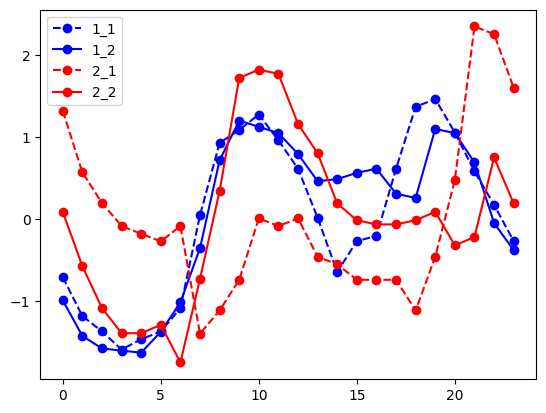

In [76]:
tb1 = X.reset_index(drop=False)
ts1 = tb1[tb1.day_ID==0]
ts2 = tb1[tb1.day_ID==1]
ts3 = tb1[tb1.day_ID==2]
ts4 = tb1[tb1.day_ID==6]

import matplotlib.pyplot as plt

plt.plot(ts1.reset_index()['total_power_demand'], color='blue', marker='o', linestyle='dashed', label = '1_1')
plt.plot(ts2.reset_index()['total_power_demand'], color='blue', marker='o',label='1_2')
plt.plot(ts3.reset_index()['total_power_demand'], color='red', marker='o', linestyle='dashed', label = '2_1')
plt.plot(ts4.reset_index()['total_power_demand'], color='red', marker='o',label='2_2')
plt.legend()
plt.show()

In [84]:
y.shape

(40,)

### Basic Motion

**Ссылка**: https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.datasets.load_basic_motions.html sktime

**Описание**: В датасете представлены результаты сбора показателей движения по 3 осям с мобильных телефонов. Задача мультиклассификации. 

Всего 4 меток классов:
1. walking,
2. resting, 
3. running,  
4. badminton

Оригинальное объяснение:
 
Dimensionality: multivariate, 6 Series length: 100 Train cases: 40 Test cases: 40 Number of classes: 4

The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

**Выводы**:

**Результат анализа:** 


In [80]:
from sktime.datasets import load_basic_motions

# load an example time series panel in pd-multiindex mtype
X, y = load_basic_motions(return_type="pd-multiindex", split="train")

# renaming columns for illustrative purposes
X.columns = ["accel_1", "accel_2", "accel_3", "gyro_1", "gyro_2", "gyro_3"]
X.index.names = ["trial_no", "timepoint"]

In [81]:
X

accel_1   accel_2   accel_3    gyro_1    gyro_2    gyro_3
trial_no timepoint                                                            
0        0          0.079106  0.394032  0.551444  0.351565  0.023970  0.633883
         1          0.079106  0.394032  0.551444  0.351565  0.023970  0.633883
         2         -0.903497 -3.666397 -0.282844 -0.095881 -0.319605  0.972131
         3          1.116125 -0.656101  0.333118  1.624657 -0.569962  1.209171
         4          1.638200  1.405135  0.393875  1.187864 -0.271664  1.739182
...                      ...       ...       ...       ...       ...       ...
39       95         1.239144 -6.142442  0.028264 -2.309144  1.472845 -0.998765
         96         0.261434  0.205915 -0.224944 -0.524684  0.769715  0.157139
         97         2.490353 -0.878765 -0.597296  0.111862 -0.117188 -0.050604
         98         4.122120  0.911620 -0.465409  0.535338  0.197090  0.442120
         99         3.169270  0.826934 -0.362036 -0.298298  0.250357  0.428803

[4000 rows x 6 columns]

In [83]:
y.shape

(40,)